In [2]:
import pandas as pd
import numpy as np
from get_sentiment import *
import nltk
import spacy
from spacy.tokens import Doc
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
plt.style.use('ggplot')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/dizquierdo/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
results = primary_species(['Candidate', 'Tweet'], 'text', 'timestamp')
data = read_cypher(results, index_col='timestamp')
sentiment_analyzer = SentimentIntensityAnalyzer()
def sentiment(doc):
    """Returns polarity score set earlier to Vader's analyzer"""
    return sentiment_analyzer.polarity_scores(doc)['compound']

In [97]:
com_results = f"""
MATCH (u:User)-[ts:TWEETS]-(t:Tweet)-[:CONTAINS]-(c:Candidate)
WHERE EXISTS (ts.timestamp)
RETURN c.screen_name as name, c.followers as followers, t.text as text, ts.timestamp as timestamp
"""

In [98]:
data = read_cypher(com_results, index_col='timestamp')

In [99]:
data.name.value_counts()

BernieSanders    38943
ewarren          16826
JoeBiden         13316
MikeBloomberg     9711
PeteButtigieg     9139
AndrewYang        2939
amyklobuchar      2554
TulsiGabbard      1194
Name: name, dtype: int64

In [100]:
data['clean_text'], data['hashtag'] = zip(*data.text.map(strip_tweets))
data = pd.merge(data, pd.get_dummies(data.hashtag.apply(pd.Series).stack()).sum(level=0), how='left', left_index=True, right_index=True).drop(['hashtag','followers'], axis=1).fillna(0)
data['sentiment'] = data.text.apply(sentiment)
data.set_index(pd.to_datetime(data.timestamp,unit='s'), inplace=True)
data['day'] = data.index.day
data.drop(['timestamp'], axis=1, inplace=True)

In [101]:
data.head()

,name,text,clean_text,#1,#14,#1600Pennsylvania,#18,#19,#1984,#1stFemalePOTUS,...,#yanggang,#yanggangforlife,#yangmediablackout,#yangunitesamerica,#yawn,#yeshedid,#yesonr,#youtoo,sentiment,day
timestamp,,,,,,,,,,,,,,,,,,,,,
2020-02-29 10:02:06,BernieSanders,@BernieSanders Oh shut up! Go buy some Clorax...,Oh shut up! Go buy some Clorax wipes and get...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,29
2020-02-29 10:02:03,BernieSanders,@ChrisEdgeworthX @GlobeOpinion @BernieSanders ...,"Yeah, peak sexism.",0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2960,29
2020-02-29 10:02:03,BernieSanders,@educated_adult2 @BernieSanders Shows how much...,Shows how much you know. Bernie was re-elect...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,29
2020-02-29 10:02:02,BernieSanders,@howardfineman @BernieSanders Bots cannot vote...,Bots cannot vote last time I checked.,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,29
2020-02-29 10:02:02,BernieSanders,@AFTWA @BernieSanders Thank You!!!,Thank You!!!,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5229,29


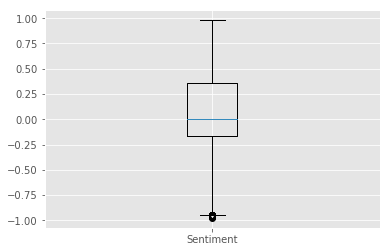

In [102]:
plt.boxplot(data.sentiment, labels=['Sentiment']);

In [103]:
data.groupby(by='name').sentiment.mean()

name
AndrewYang       0.110772
BernieSanders    0.025404
JoeBiden         0.046690
MikeBloomberg    0.006276
PeteButtigieg    0.047285
TulsiGabbard     0.039145
amyklobuchar     0.075990
ewarren          0.050790
Name: sentiment, dtype: float64

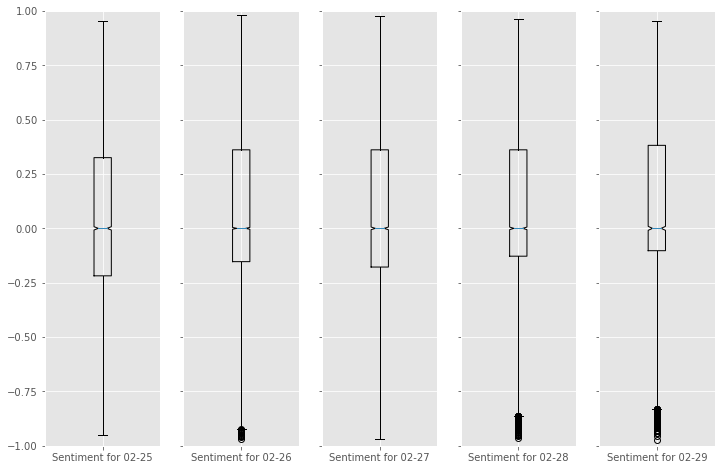

In [104]:
days = set(data['2020-02-25':'2020-03-03'].day.values)
fig, ax = plt.subplots(1,len(days), figsize=(12,8), sharey=True)
for count, day in enumerate(days):
    subset = data['2020-02-25':'2020-03-03'].query(f'day =={day}')
    ax[count].boxplot(subset.sentiment, notch=True, labels=[f'Sentiment for 02-{day}'])
    axes = plt.gca()
    axes.set_ylim([-1,1])
#     axes.set_yticklabels(map(lambda x: x/10, list(range(-10,10))))

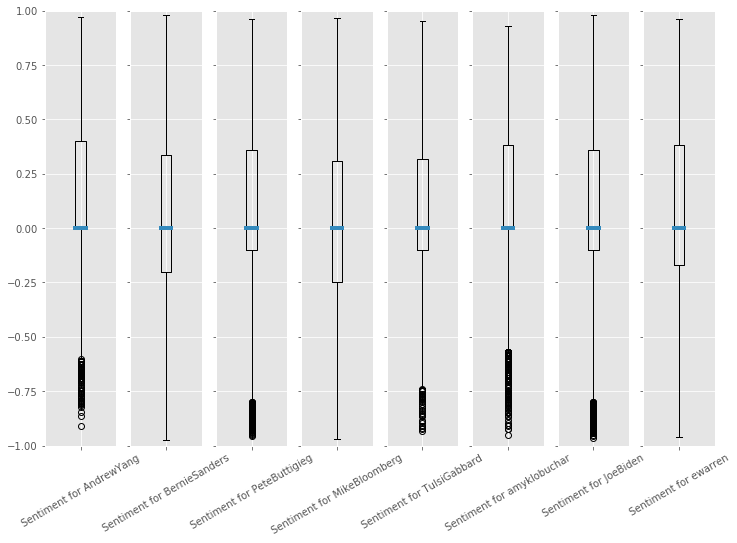

In [105]:
candidates = set(data['2020-02-25':'2020-02-29'].name.values)
fig, ax = plt.subplots(1,len(candidates), figsize=(12,8), sharey=True)
for count, candidate in enumerate(candidates):
    subset = data['2020-02-25':'2020-02-29'].query(f'name=="{candidate}"')
    ax[count].boxplot(subset.sentiment, notch=False, labels=[f'Sentiment for {candidate}'], 
                      medianprops={'linewidth': 4})
    axes = plt.gca()
    axes.set_ylim([-1,1])
    for tick in ax[count].get_xticklabels():
        tick.set_rotation(30)
#     axes.set_yticklabels(map(lambda x: x/10, list(range(-10,10))))

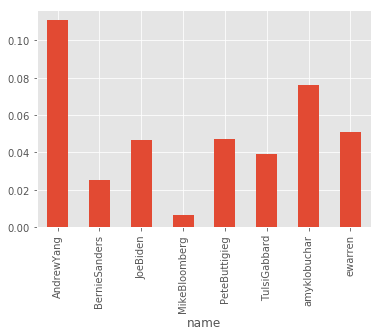

In [106]:
candidate_mean = data['2020-02-25':'2020-02-29'].groupby('name').sentiment.mean()
candidate_mean.plot(kind='bar');

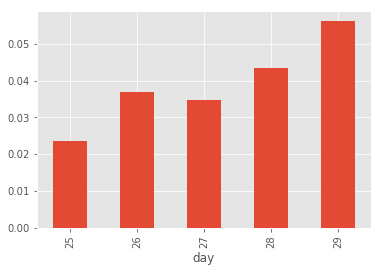

In [107]:
day_mean = data['2020-02-25':'2020-02-29'].groupby('day').sentiment.mean()
day_mean.plot(kind='bar');

In [ ]:
max_sentiment = data.sentiment.max()
min_sentiment = data.sentiment.min()
max_sent_tweet = data[(data['sentiment'] == max_sentiment)]['clean_text'].values[0]
min_sent_tweet = data[(data['sentiment'] == min_sentiment)]['clean_text'].values[0]
max_sent_sender = data[(data['sentiment'] == max_sentiment)]['name'].values[0]
min_sent_sender = data[(data['sentiment'] == min_sentiment)]['name'].values[0]
g = sns.boxplot(y = "name",
              x = 'sentiment', 
              data = data, whis=np.inf, width=.5)
g = sns.swarmplot(y = "name",
              x = 'sentiment', 
              data = data,
              size = 5,color='black')
plt.ylabel('Candidate')
plt.xlabel('Sentiment')
# remove the top and right line in graph
sns.despine()
# Annotate. xy for coordinate. max_wage is x and 0 is y. In this plot y ranges from 0 to 7 for each level
# xytext for coordinates of where I want to put my text
for count, tick in enumerate(g.yaxis.get_major_ticks()):
    if max_sent_sender == tick.label.get_text():
        max_sent_y = count
    if min_sent_sender == tick.label.get_text():
        min_sent_y = count
plt.annotate(s = '"'+max_sent_tweet+'"',
             xy = (max_sentiment,max_sent_y),
             xytext = (max_sentiment,max_sent_y-.4), 
             # Shrink the arrow to avoid occlusion
             arrowprops = {'facecolor':'blue', 'width': 3, 'shrink': 0.03},
             ha='right',
             alpha=.9,
             color = 'blue')
plt.annotate(s = '"'+min_sent_tweet+'"',
             xy = (min_sentiment,min_sent_y),
             xytext = (min_sentiment-.1,min_sent_y-.6), 
             # Shrink the arrow to avoid occlusion
             arrowprops = {'facecolor':'blue', 'width': 3, 'shrink': 0.03},
             horizontalalignment='left',
             alpha=.9,
             color = 'blue')
g.figure.set_size_inches(12,8)
plt.show();

In [14]:
def winter_time(t_index):
    """Convert DateTime to equivalent polar coordinate 0=Midnight, Pi=Noon. Vectorize if possible."""
    since_midnight = t_index.hour * 3600 + t_index.minute * 60 + t_index.second
    polar_time = np.pi*2*since_midnight /60/60/24
    return polar_time.values

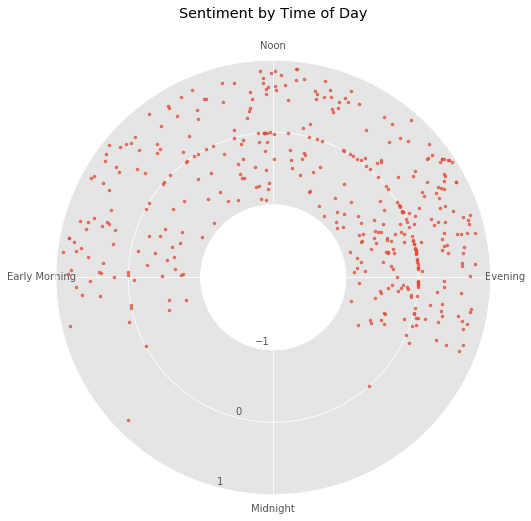

In [15]:
subset = data['2020-02-25':'2020-03-03']
# subset=subset.iloc[10:15]
fig = plt.figure(figsize=(12,8))
r = subset.sentiment
subset['theta'] = winter_time(subset.index)
ax = fig.add_subplot(111, polar=True)
ax.set_rorigin(-2)
ax.set_rlim(-1,1)
ax.set_rgrids([-1,0,1])
ax.set_theta_zero_location('S', 210)
ax.set_theta_direction(-1)
ax.set_rlabel_position(225)
offset = [210,300,30,120]
ax.set_thetagrids(angles = offset,
                  labels = ('Midnight', 'Early Morning', 'Noon', 'Evening'))
c = ax.scatter(subset['theta'], subset['sentiment'], alpha=0.75, marker='.')
plt.title('Sentiment by Time of Day', pad=20);
# for idx, point in subset.iterrows():
#     plt.annotate(s = idx.time(),
#              xy = (point.theta, point.sentiment),
#              xytext = (point.theta-.2,point.sentiment+1), 
#              # Shrink the arrow to avoid occlusion
#              arrowprops = {'facecolor':'blue', 'width': 3, 'shrink': 0.03},
#              horizontalalignment='left',
#              alpha=.7)

In [16]:
real_candidates = ['MikeBloomberg','BernieSanders','JoeBiden', 'ewarren']

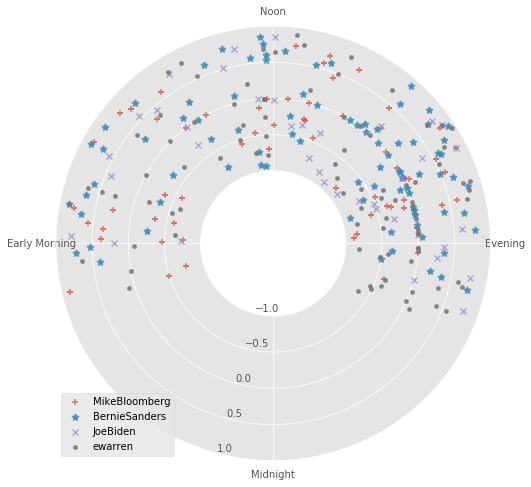

In [17]:
fig, axes = plt.subplots(1,len(real_candidates), figsize=(12,8))
legends = {'ewarren': '.', 'BernieSanders':'*', 'MikeBloomberg':'+', 'JoeBiden':'x'}
for count, candidate in enumerate(real_candidates):
    subset = data['2020-02-25':'2020-03-03'].query(f'name=="{candidate}"')
    subset['theta'] = winter_time(subset.index)
    fig = plt.subplot(polar=True)
    ax = plt.gca()
    ax.set_rorigin(-2)
    ax.set_rlim(-1,1)
    ax.set_theta_zero_location('S', 210)
    ax.set_theta_direction(-1)
    ax.set_rlabel_position(225)
    offset = [210,300,30,120]
    ax.set_rticks([-1,-.5,0,.5,1])
    ax.set_thetagrids(angles = offset,
                      labels = ('Midnight', 'Early Morning', 'Noon', 'Evening'))
    c = ax.scatter(subset['theta'], subset['sentiment'], alpha=0.75, marker=legends[candidate], linewidths=2)
    plt.legend(real_candidates)

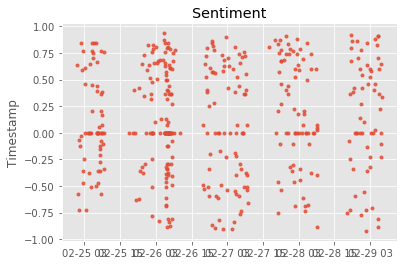

In [18]:
fig, ax = plt.subplots()
ax.plot(data.loc['2020-02-25':'2020-02-29', 'sentiment'], marker='.', alpha=.8, linestyle='None')
ax.set_ylabel('Timestamp')
ax.set_title('Sentiment');

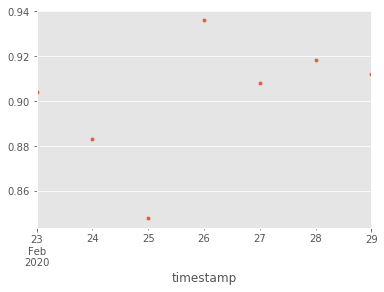

In [19]:
data.loc['2020-02-23':'2020-02-29', 'sentiment'].resample('D').max().plot(marker='.', alpha=0.8, linestyle='None');

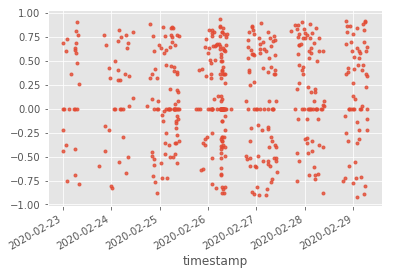

In [20]:
data.loc['2020-02-23':'2020-02-29', 'sentiment'].plot(marker='.', alpha=0.8, linestyle='None')

In [21]:
word_count = Counter(" ".join([re.sub(r'\s',' ',tweet).strip() for tweet in data.clean_text.values]).split())

In [22]:
word_count.most_common(10)

[('to', 494),
 ('the', 484),
 ('a', 310),
 ('and', 279),
 ('of', 246),
 ('I', 218),
 ('in', 216),
 ('is', 200),
 ('for', 200),
 ('we', 121)]

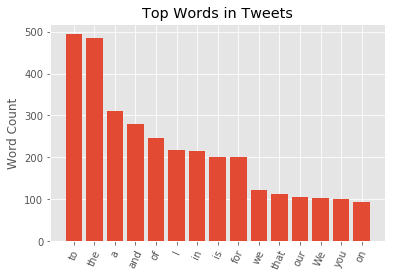

In [23]:
plt.bar([word[0] for word in word_count.most_common(15)], [word[1] for word in word_count.most_common(15)])
plt.xticks(rotation=65)
plt.ylabel('Word Count')
plt.title('Top Words in Tweets')
plt.show();

In [24]:
stopwords_list=stopwords.words('english') +list(string.punctuation)
stopwords_list += ["&amp;","'",'"','...','``','…','’','‘','“',"''",'""','”','”','co',"'s'",'\'s','n\'t','\'m','\'re','amp','https']
    

In [25]:
poli_freq = wordfrequency(data.clean_text.values, 20)

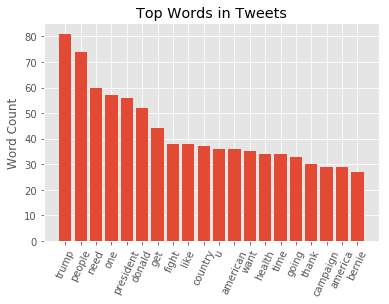

In [26]:
plt.bar([word[0] for word in poli_freq], [word[1] for word in poli_freq])
plt.xticks(rotation=65)
plt.ylabel('Word Count')
plt.title('Top Words in Tweets')
plt.show;

In [72]:
mask = np.array(Image.open(requests.get(
    'https://cdn.clipart.email/1dd93a03754697ae7c159f7c471f7ab5_usa-silhouette-lower-48-icons-png-free-png-and-icons-downloads_2398-1489.png',
    stream=True).raw))

In [57]:
def create_wordcloud2(series, tag=False, top=200):
    """ Take in a list of lists and create a WordCloud visualization for those terms.
    Parameters:
            series (iterable): A list of lists containing strings.
    Returns:
        None: The output is a visualization of the strings in series in terms of the
            frequency of their occurrence.
    """
    vocab = tokenized(series)
    cloud = WordCloud(background_color='whitesmoke', max_words=top, mask=mask , #width=400, height=300,
                      contour_width=3, contour_color='crimson').generate(' '.join([word for word in vocab]))
    plt.figure(figsize=(24, 12))
    plt.imshow(cloud, interpolation='bilinear')
    if tag:
        plt.title(f'Most Common words for {tag}')
    else:
        plt.title(f'Most Common Words')
    plt.axis('off')
    # plt.tight_layout(pad=0)
    plt.show();

In [62]:
def create_wordcloud2(series, tag=False, top=200):
    """ Take in a list of lists and create a WordCloud visualization for those terms.
    Parameters:
            series (iterable): A list of lists containing strings.
    Returns:
        None: The output is a visualization of the strings in series in terms of the
            frequency of their occurrence.
    """
    vocab = tokenized(series)
    cloud = WordCloud(background_color='whitesmoke', max_words=top, mask=mask , width=400, height=300,
                      contour_width=3, contour_color='crimson').generate(' '.join([word for word in vocab]))
    plt.figure(figsize=(24, 12))
    plt.imshow(cloud, interpolation='bilinear')
    if tag:
        plt.title(f'Most Common words for {tag}')
    else:
        plt.title(f'Most Common Words')
    plt.axis('off')
    # plt.tight_layout(pad=0)
    plt.show();

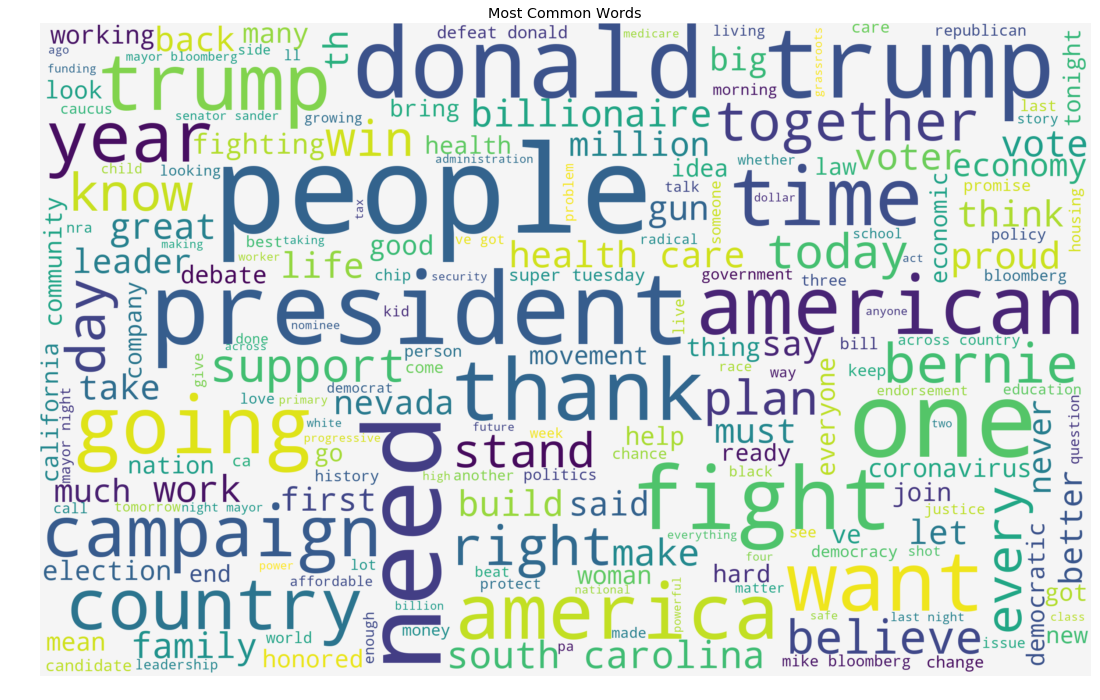

In [73]:
create_wordcloud2(data.clean_text.values)

In [5]:
from nltk.collocations import *
bigram_measures = nltk.collocations.BigramAssocMeasures()

In [15]:
from nltk.collocations import BigramCollocationFinder as big_find

In [36]:
tweets = [tweet[0] for tweet in clean_tweets]
vocab = tokenized(tweets)
big = big_find.from_words(vocab)
# b.apply_freq_filter(1)
big_measures = nltk.collocations.BigramAssocMeasures()
bestBigrams = big.above_score(score_fn=big_measures.raw_freq, min_score=1.0/len(tuple(nltk.bigrams(tweets))))
vocab += bestBigrams